# Компʼютерний практикум №10
Виконав студент групи ЗК-41мп Гломозда Костянтин

УДОСКОНАЛЕННЯ ЗГОРТКОВОЇ НЕЙРОННОЇ МЕРЕЖІ LENET5. BATCH NORMALIZATION

Імпортуємо модулі

In [99]:
import torch
import numpy as np


seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

Створюємо нейронну мережу

In [100]:
class SimpleNet(torch.nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.activation = activation
        self.fc1 = torch.nn.Linear(1, 1, bias=False) # one neuron without bias
        self.fc1.weight.data.fill_(1.) # init weight with 1
        self.fc2 = torch.nn.Linear(1, 1, bias=False)
        self.fc2.weight.data.fill_(1.)
        self.fc3 = torch.nn.Linear(1, 1, bias=False)
        self.fc3.weight.data.fill_(1.)
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return x
    def get_fc1_grad_abs_value(self):
        return torch.abs(self.fc1.weight.grad)
    
def get_fc1_grad_abs_value(net, x):
    output = net.forward(x)
    output.backward() # no loss function. Pretending that we want to minimize output
    # In our case output is scalar, so we can calculate backward
    fc1_grad = net.get_fc1_grad_abs_value().item()
    net.zero_grad()
    return fc1_grad

Run experiment with different activations

In [101]:
activations = {
    'ELU': torch.nn.ELU(),
    'Hardtanh': torch.nn.Hardtanh(),
    'LeakyReLU': torch.nn.LeakyReLU(),
    'LogSigmoid': torch.nn.LogSigmoid(),
    'PReLU': torch.nn.PReLU(),
    'ReLU': torch.nn.ReLU(),
    'ReLU6': torch.nn.ReLU6(),
    'RReLU': torch.nn.RReLU(),
    'SELU': torch.nn.SELU(),
    'CELU': torch.nn.CELU(),
    'Sigmoid': torch.nn.Sigmoid(),
    'Softplus': torch.nn.Softplus(),
    'Softshrink': torch.nn.Softshrink(),
    'Softsign': torch.nn.Softsign(),
    'Tanh': torch.nn.Tanh(),
    'Tanhshrink': torch.nn.Tanhshrink(),
    'Hardshrink': torch.nn.Hardshrink()
}

NUMBER_OF_EXPERIMENTS = 200
means = {}
for name, activation in activations.items():
    net = SimpleNet(activation=activation)
    
    fc1_grads = []
    for x in torch.randn((NUMBER_OF_EXPERIMENTS, 1)):
        fc1_grads.append(get_fc1_grad_abs_value(net, x))
        
    means[name] = np.mean(fc1_grads)
    print(f"Activation {name}: {means[name]}")

maximum = max(means, key=means.get)
print(f"Best Activation is {maximum}: {means[maximum]}")

Activation ELU: 0.5130936071489123
Activation Hardtanh: 0.3301656365673989
Activation LeakyReLU: 0.3912024556372764
Activation LogSigmoid: 0.32004617214231984
Activation PReLU: 0.43562054235598224
Activation ReLU: 0.4092417423520237
Activation ReLU6: 0.3963189114443958
Activation RReLU: 0.36756316786555543
Activation SELU: 0.6040668689087033
Activation CELU: 0.4036044550893712
Activation Sigmoid: 0.007264371898836544
Activation Softplus: 0.24449487038655207
Activation Softshrink: 0.2813682162761688
Activation Softsign: 0.06567702983273194
Activation Tanh: 0.1630371836863924
Activation Tanhshrink: 0.00868728815764078
Activation Hardshrink: 0.6825883448123932
Best Activation is Hardshrink: 0.6825883448123932


LeNet Model

In [102]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation: torch.nn.Module = torch.nn.ReLU(),
                 pooling: torch.nn.Module = torch.nn.AvgPool2d(kernel_size=2, stride=2),
                 conv_size=5,
                 use_batch_norm=False):
        
        super(LeNet5, self).__init__()
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        self.activation = activation
        self.pooling = pooling
        
        if conv_size not in [3, 5]:
            raise NotImplementedError("conv_size must be either 3 or 5")
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=conv_size, padding=2 if conv_size == 5 else 1)
        self.act1 = activation
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling
        
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=conv_size, padding=0)
        self.act2 = activation
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling
        
        # Dynamically compute the size of the input to the fully connected layers
        self._to_linear = None
        self._get_conv_output_size()

        self.fc1 = torch.nn.Linear(self._to_linear, 120)
        self.act3 = activation
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation
        self.fc3 = torch.nn.Linear(84, 10)

    def _get_conv_output_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)  # CIFAR-10 input size
            x = self.conv1(dummy_input)
            x = self.pool1(x)
            x = self.conv2(x)
            x = self.pool2(x)
            self._to_linear = x.view(1, -1).size(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x

Train function

In [103]:
def train(net, X_train, y_train, X_test, y_test, epochs=30, batch_size=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    test_accuracy_history = []
    test_loss_history = []
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    for _ in range(epochs):
        order = np.random.permutation(len(X_train))
        
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            preds = net.forward(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        
        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
    return test_accuracy_history, test_loss_history

Export data

In [3]:
import torchvision
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

def extract_data(loader):
    X, y = [], []
    for data in loader:
        inputs, labels = data
        X.append(inputs)
        y.append(labels)
    return torch.cat(X), torch.cat(y)

X_train, y_train = extract_data(train_loader)
X_val, y_val = extract_data(val_loader)
X_test, y_test = extract_data(test_loader)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Files already downloaded and verified
Files already downloaded and verified
Training data shape: torch.Size([40000, 3, 32, 32]), torch.Size([40000])
Validation data shape: torch.Size([10000, 3, 32, 32]), torch.Size([10000])
Testing data shape: torch.Size([10000, 3, 32, 32]), torch.Size([10000])


Train multiple networks

In [108]:
activations = {
    'ReLU': torch.nn.ReLU(),
    'LeakyReLU': torch.nn.LeakyReLU(),
    'ELU': torch.nn.ELU()
}
accuracies = {}
losses = {}

conv_sizes = [3, 5]
for conv_size in conv_sizes:
    for name, activation in activations.items():
        print(f"Training with activation {name} and conv_size {conv_size}")
        net = LeNet5(activation=activation, conv_size=conv_size, use_batch_norm=True)
        accuracy_history, loss_history = train(net, X_train, y_train, X_test, y_test, epochs=20)
        accuracies[(name, conv_size)] = accuracy_history
        losses[(name, conv_size)] = loss_history
        print(f"Final accuracy: {accuracy_history[-1]:.3f}")
        print(f"Final loss: {loss_history[-1]:.3f}")
        print()

Training with activation ReLU and conv_size 3
Final accuracy: 0.631
Final loss: 2.194

Training with activation LeakyReLU and conv_size 3
Final accuracy: 0.635
Final loss: 2.196

Training with activation ELU and conv_size 3
Final accuracy: 0.627
Final loss: 2.053

Training with activation ReLU and conv_size 5
Final accuracy: 0.639
Final loss: 1.828

Training with activation LeakyReLU and conv_size 5
Final accuracy: 0.637
Final loss: 1.756

Training with activation ELU and conv_size 5
Final accuracy: 0.615
Final loss: 1.730



Найкраще з усіх показала себе LeakyReLU, conv_size=5

Фільтри: В кожному згортковому шарі збільшено кількість фільтрів, що дозволяє отримувати більше інформації з зображень.

Паддінг: Застосовано padding=1 для кожної згортки, щоб розмір зображення залишався незмінним після згортки.

Batch Normalization: Додано нормалізацію для вхідних зображень та після кожного згорткового шару для кращої стабільності навчання.

Dropout: Додано Dropout перед повнозв'язними шарами для боротьби з перенавчанням.

L2-регуляризація: Використано параметр weight_decay для оптимізатора Adam, щоб додати 

L2-регуляризацію. Значення 1e-4 забезпечує хорошу балансування між регуляризацією та здатністю моделі навчатись.

In [7]:
import torch
import numpy as np


class ModifiedNet(torch.nn.Module):
    def __init__(self):
        super(ModifiedNet, self).__init__()
        
        # BatchNorm for input normalization (3 channels for RGB)
        self.bn_input = torch.nn.BatchNorm2d(3)

        # First conv block: Conv2d -> ReLU -> BatchNorm -> MaxPool
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Second conv block: Conv2d -> ReLU -> BatchNorm -> MaxPool
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Third conv block: Conv2d -> ReLU -> BatchNorm -> MaxPool
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = torch.nn.Linear(64 * 4 * 4, 256)
        self.bn_fc1 = torch.nn.BatchNorm1d(256)
        self.fc2 = torch.nn.Linear(256, 64)
        self.bn_fc2 = torch.nn.BatchNorm1d(64)
        self.fc3 = torch.nn.Linear(64, 10)

        # Activation functions
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()

        # Dropout layers
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.bn_input(x)
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.bn_fc1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.bn_fc2(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        return x

def train_with_l2(net, X_train, y_train, X_test, y_test, epochs=30, batch_size=100, weight_decay=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=weight_decay)
    
    test_accuracy_history = []
    test_loss_history = []
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    for _ in range(epochs):
        order = np.random.permutation(len(X_train))
        
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            preds = net.forward(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        
        net.eval()
        test_preds = net.forward(X_test)
        test_loss_history.append(loss(test_preds, y_test).data.cpu())
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)
    return test_accuracy_history, test_loss_history

# Training the model with the modified architecture
net = ModifiedNet()
accuracy_history, loss_history = train_with_l2(net, X_train, y_train, X_test, y_test, epochs=50, weight_decay=1e-4)
print(f"Final accuracy: {accuracy_history[-1]:.3f}")
print(f"Final loss: {loss_history[-1]:.3f}")

Final accuracy: 0.754
Final loss: 0.953


Попередній кращий результат:

Training with activation LeakyReLU and conv_size 5

Final accuracy: 0.637
Final loss: 1.756

Можемо побачити що застосовані методи збільшили точність та зменшили помилку

Plot results

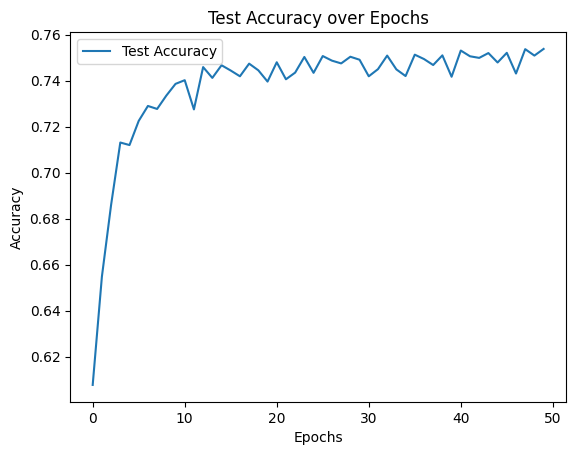

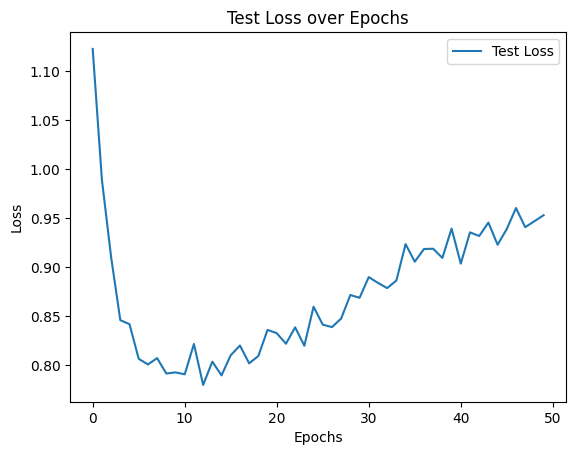

In [12]:
import matplotlib.pyplot as plt

plt.plot(accuracy_history, label='Test Accuracy')
plt.title("Test Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(loss_history, label='Test Loss')
plt.title("Test Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Висновок - можемо застосувати меншу кількість епох для отримання кращих результатів